In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import time

In [2]:
X = pd.read_csv('./IDA project dataset/train_x.csv').drop(['ID'], axis=1)
y = pd.read_csv('./IDA project dataset/train_y.csv').drop(['ID'], axis=1)

X['y'] = y

X_nona = pd.get_dummies(X.dropna(), columns=['Loan type', 'Occupation type'])
y = X_nona['y'].to_numpy()
X = X_nona.drop(['y'], axis=1).to_numpy()

X.shape, y.shape

((59238, 13), (59238,))

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [4]:
def normal_pdf(x, mean, cov):
    x_m = x.reshape(-1, 1) - mean
    pdf = np.exp(np.matmul(np.matmul(x_m.T, np.linalg.inv(cov)),
                           x_m)*-1/2)[0][0]
    pdf /= (2*np.pi)**(cov.shape[0]/2)
    pdf /= np.linalg.det(cov)**0.5
    return pdf

# Naive Bayes (Diagonal Co-variance matrix)

In [5]:
class Naive_Bayes:
    def __init__(self):
        return None
        
    def fit(self, X_train, y_train):
        X_train_pos = X_train[y_train == 1]
        X_train_neg = X_train[y_train == 0]
        self.P_pos = np.sum(y_train == 1)/y_train.shape[0]
        self.P_neg = np.sum(y_train == 0)/y_train.shape[0]

        self.mean_pos = np.mean(X_train_pos, axis=0).reshape(-1, 1)
        self.mean_neg = np.mean(X_train_neg, axis=0).reshape(-1, 1)

        self.cov_pos = np.identity(X_train.shape[1])
        self.cov_neg = np.identity(X_train.shape[1])
        
    def predict(self, X_test):
        y_test_pred = []
        for x in X_test:
            pos = normal_pdf(x, self.mean_pos, self.cov_pos)
            neg = normal_pdf(x, self.mean_neg, self.cov_neg)

            prob = self.P_pos*pos/(self.P_pos*pos+self.P_neg*neg)
            y_test_pred.append(1 if prob>0.5 else 0)
        
        return np.array(y_test_pred)

Class weights : [1, 1]
Validation set Accuracy : 0.958
Validation set F1 score : 0.535


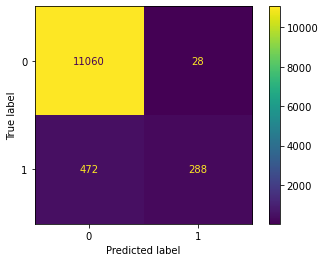

Class weights : [1, 2]
Validation set Accuracy : 0.961
Validation set F1 score : 0.602


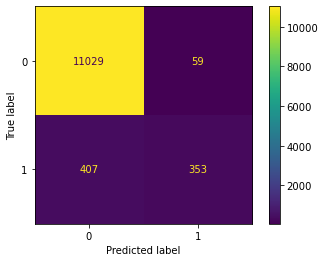

Class weights : [1, 3]
Validation set Accuracy : 0.961
Validation set F1 score : 0.636


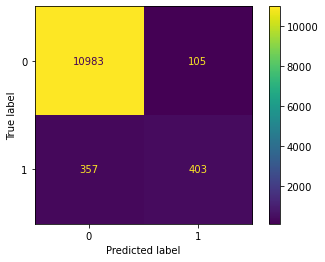

Class weights : [1, 4]
Validation set Accuracy : 0.958
Validation set F1 score : 0.637


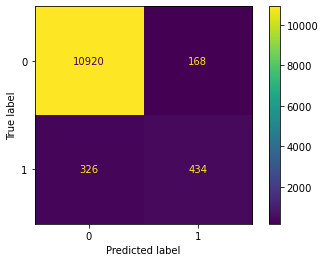

Class weights : [1, 5]
Validation set Accuracy : 0.956
Validation set F1 score : 0.640


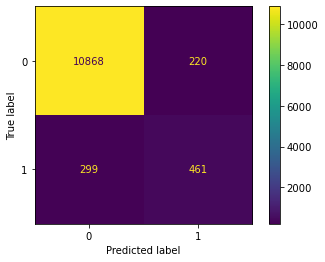

Class weights : [1, 6]
Validation set Accuracy : 0.951
Validation set F1 score : 0.627


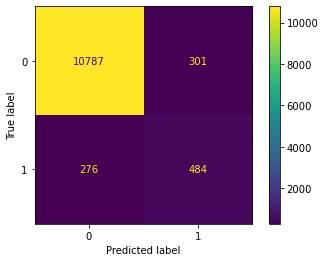

Class weights : [1, 7]
Validation set Accuracy : 0.945
Validation set F1 score : 0.610


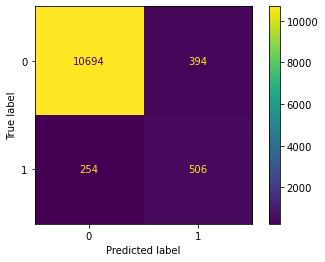

Class weights : [1, 8]
Validation set Accuracy : 0.937
Validation set F1 score : 0.579


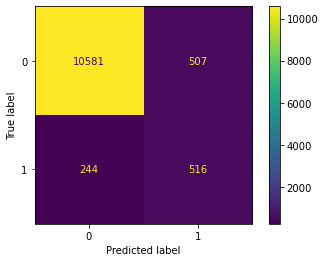

Class weights : [1, 9]
Validation set Accuracy : 0.929
Validation set F1 score : 0.561


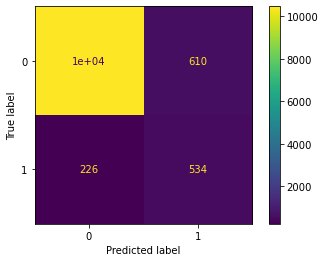

Class weights : [1, 10]
Validation set Accuracy : 0.921
Validation set F1 score : 0.539


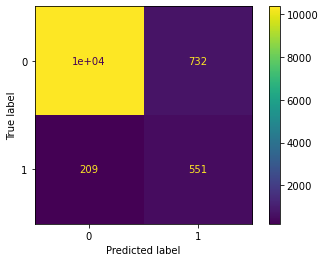

In [6]:
F1_score = []
params = {}

X_train_pca_1 = X_train_pca[y_train==1]
X_train_pca_0 = X_train_pca[y_train==0]

for weight in tqdm(range(1, 11)):
    print('===============================================================================')
    print('Class weights : [1, {0}]'.format(weight))
    
    X_train_norm = np.concatenate((X_train_pca_0, np.tile(X_train_pca_1, (weight, 1))), axis=0)
    y_train_norm = np.concatenate((np.zeros(X_train_pca_0.shape[0]), 
                                   np.ones(weight*X_train_pca_1.shape[0])), axis=0)
    X_train_norm, y_train_norm = shuffle(X_train_norm, y_train_norm, random_state=0)
    
    clf = make_pipeline(StandardScaler(), Naive_Bayes())
    clf.fit(X_train_norm, y_train_norm)
    y_val_pred = clf.predict(X_val_pca)
    
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    print("Validation set Accuracy : {0:.3f}".format(val_acc))
    print("Validation set F1 score : {0:.3f}".format(val_f1))
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0', '1'])
    disp.plot()
    plt.show()
    
    F1_score.append(val_f1)
    params[str(val_f1)] = weight

In [7]:
params[str(max(F1_score))], max(F1_score)

(5, 0.6398334489937544)

# Bayes (Same Co-variance matrix)

In [8]:
class Equi_Bayes:
    def __init__(self):
        return None
        
    def fit(self, X_train, y_train):
        X_train_pos = X_train[y_train == 1]
        X_train_neg = X_train[y_train == 0]
        self.P_pos = np.sum(y_train == 1)/y_train.shape[0]
        self.P_neg = np.sum(y_train == 0)/y_train.shape[0]

        self.mean_pos = np.mean(X_train_pos, axis=0).reshape(-1, 1)
        self.mean_neg = np.mean(X_train_neg, axis=0).reshape(-1, 1)

        self.cov_pos = np.cov(X_train.T)
        self.cov_neg = np.cov(X_train.T)
        
    def predict(self, X_test):
        y_test_pred = []
        for x in X_test:
            pos = normal_pdf(x, self.mean_pos, self.cov_pos)
            neg = normal_pdf(x, self.mean_neg, self.cov_neg)

            prob = self.P_pos*pos/(self.P_pos*pos+self.P_neg*neg)
            y_test_pred.append(1 if prob>0.5 else 0)
        
        return np.array(y_test_pred)

Class weights : [1, 1]
Validation set Accuracy : 0.958
Validation set F1 score : 0.535


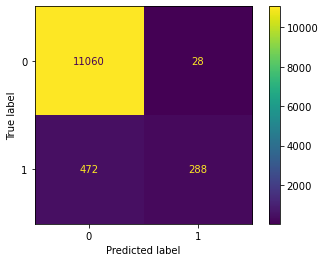

Class weights : [1, 2]
Validation set Accuracy : 0.959
Validation set F1 score : 0.559


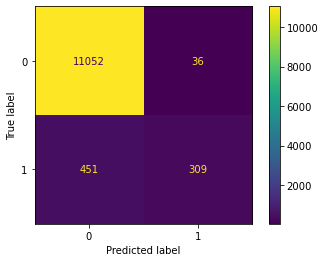

Class weights : [1, 3]
Validation set Accuracy : 0.960
Validation set F1 score : 0.578


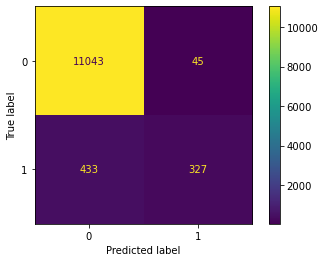

Class weights : [1, 4]
Validation set Accuracy : 0.960
Validation set F1 score : 0.600


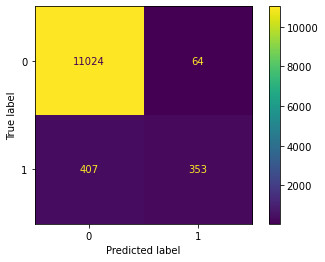

Class weights : [1, 5]
Validation set Accuracy : 0.961
Validation set F1 score : 0.625


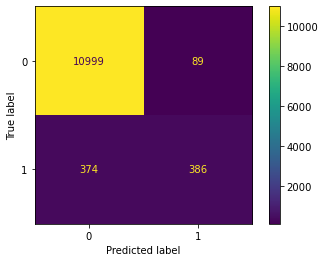

Class weights : [1, 6]
Validation set Accuracy : 0.960
Validation set F1 score : 0.638


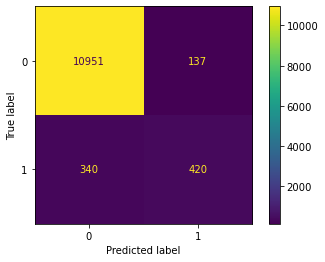

Class weights : [1, 7]
Validation set Accuracy : 0.956
Validation set F1 score : 0.630


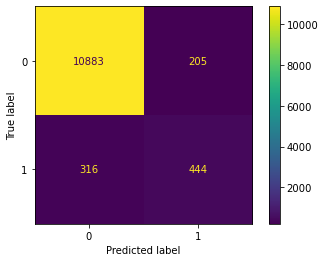

Class weights : [1, 8]
Validation set Accuracy : 0.952
Validation set F1 score : 0.625


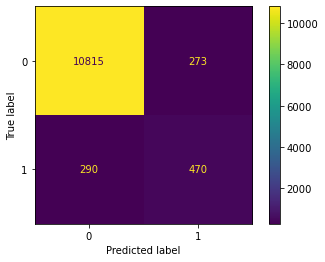

Class weights : [1, 9]
Validation set Accuracy : 0.947
Validation set F1 score : 0.611


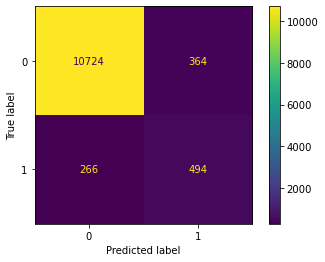

Class weights : [1, 10]
Validation set Accuracy : 0.939
Validation set F1 score : 0.588


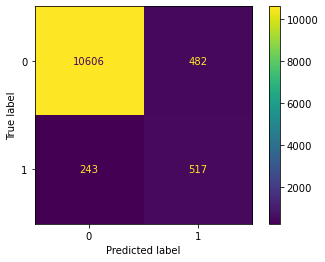

In [9]:
F1_score = []
params = {}

X_train_pca_1 = X_train_pca[y_train==1]
X_train_pca_0 = X_train_pca[y_train==0]

for weight in tqdm(range(1, 11)):
    print('===============================================================================')
    print('Class weights : [1, {0}]'.format(weight))
    
    X_train_norm = np.concatenate((X_train_pca_0, np.tile(X_train_pca_1, (weight, 1))), axis=0)
    y_train_norm = np.concatenate((np.zeros(X_train_pca_0.shape[0]), 
                                   np.ones(weight*X_train_pca_1.shape[0])), axis=0)
    X_train_norm, y_train_norm = shuffle(X_train_norm, y_train_norm, random_state=0)
    
    clf = make_pipeline(StandardScaler(), Equi_Bayes())
    clf.fit(X_train_norm, y_train_norm)
    y_val_pred = clf.predict(X_val_pca)
    
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    print("Validation set Accuracy : {0:.3f}".format(val_acc))
    print("Validation set F1 score : {0:.3f}".format(val_f1))
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0', '1'])
    disp.plot()
    plt.show()
    
    F1_score.append(val_f1)
    params[str(val_f1)] = weight

In [10]:
params[str(max(F1_score))], max(F1_score)

(6, 0.6378132118451025)

# Bayes (Different Co-variance matrix)

In [11]:
class Multi_Bayes:
    def __init__(self):
        return None
        
    def fit(self, X_train, y_train):
        X_train_pos = X_train[y_train == 1]
        X_train_neg = X_train[y_train == 0]
        self.P_pos = np.sum(y_train == 1)/y_train.shape[0]
        self.P_neg = np.sum(y_train == 0)/y_train.shape[0]

        self.mean_pos = np.mean(X_train_pos, axis=0).reshape(-1, 1)
        self.mean_neg = np.mean(X_train_neg, axis=0).reshape(-1, 1)

        self.cov_pos = np.cov(X_train_pos.T)
        self.cov_neg = np.cov(X_train_neg.T)
        
    def predict(self, X_test):
        y_test_pred = []
        for x in X_test:
            pos = normal_pdf(x, self.mean_pos, self.cov_pos)
            neg = normal_pdf(x, self.mean_neg, self.cov_neg)

            prob = self.P_pos*pos/(self.P_pos*pos+self.P_neg*neg)
            y_test_pred.append(1 if prob>0.5 else 0)
        
        return np.array(y_test_pred)

Class weights : [1, 1]
Validation set Accuracy : 0.973
Validation set F1 score : 0.765


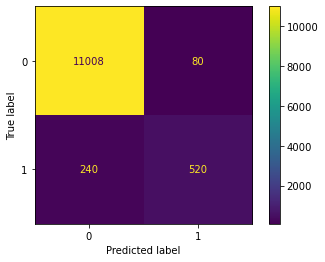

Class weights : [1, 2]
Validation set Accuracy : 0.971
Validation set F1 score : 0.768


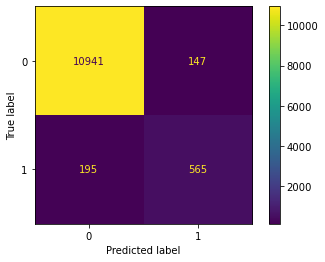

Class weights : [1, 3]
Validation set Accuracy : 0.967
Validation set F1 score : 0.751


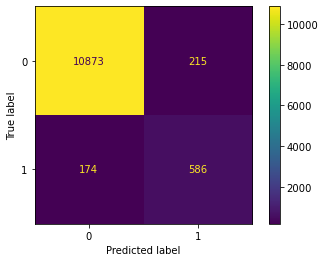

Class weights : [1, 4]
Validation set Accuracy : 0.963
Validation set F1 score : 0.736


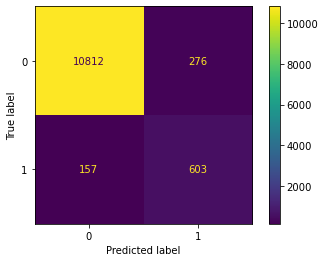

Class weights : [1, 5]
Validation set Accuracy : 0.960
Validation set F1 score : 0.724


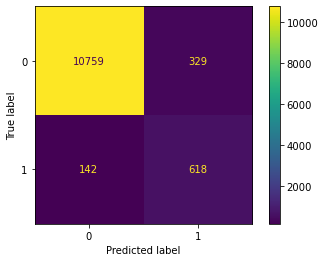

Class weights : [1, 6]
Validation set Accuracy : 0.959
Validation set F1 score : 0.720


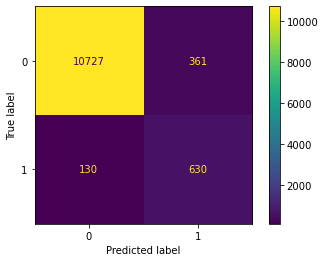

Class weights : [1, 7]
Validation set Accuracy : 0.955
Validation set F1 score : 0.704


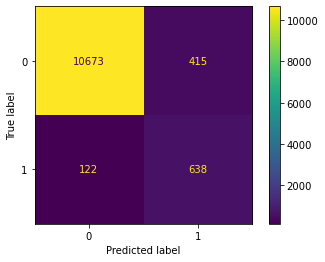

Class weights : [1, 8]
Validation set Accuracy : 0.951
Validation set F1 score : 0.690


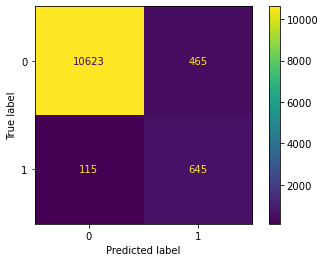

Class weights : [1, 9]
Validation set Accuracy : 0.948
Validation set F1 score : 0.679


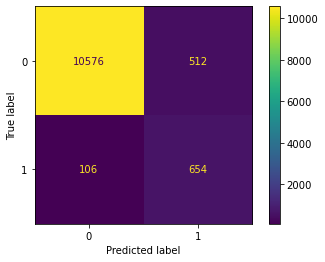

Class weights : [1, 10]
Validation set Accuracy : 0.944
Validation set F1 score : 0.667


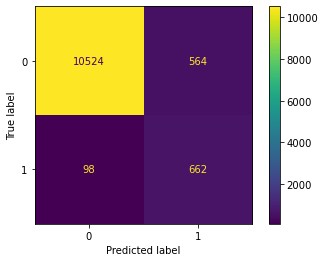

In [12]:
F1_score = []
params = {}

X_train_pca_1 = X_train_pca[y_train==1]
X_train_pca_0 = X_train_pca[y_train==0]

for weight in tqdm(range(1, 11)):
    print('===============================================================================')
    print('Class weights : [1, {0}]'.format(weight))
    
    X_train_norm = np.concatenate((X_train_pca_0, np.tile(X_train_pca_1, (weight, 1))), axis=0)
    y_train_norm = np.concatenate((np.zeros(X_train_pca_0.shape[0]), 
                                   np.ones(weight*X_train_pca_1.shape[0])), axis=0)
    X_train_norm, y_train_norm = shuffle(X_train_norm, y_train_norm, random_state=0)
    
    clf = make_pipeline(StandardScaler(), Multi_Bayes())
    clf.fit(X_train_norm, y_train_norm)
    y_val_pred = clf.predict(X_val_pca)
    
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    print("Validation set Accuracy : {0:.3f}".format(val_acc))
    print("Validation set F1 score : {0:.3f}".format(val_f1))
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0', '1'])
    disp.plot()
    plt.show()
    
    F1_score.append(val_f1)
    params[str(val_f1)] = weight

In [13]:
params[str(max(F1_score))], max(F1_score)

(2, 0.767663043478261)